In [3]:
!pip install torch torchvision torchaudio

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [28]:
wine_data = load_wine()
X = wine_data.data       
y = wine_data.target      

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Train set size:", X_train.shape)
print("Test set size:", X_test.shape)


Train set size: (142, 13)
Test set size: (36, 13)


In [26]:
class WineDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.astype(np.float32) 
        self.y = y.astype(np.int64)    

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
       
        features = self.X[idx]
        label = self.y[idx]
        return features, label
train_dataset = WineDataset(X_train, y_train)
test_dataset = WineDataset(X_test, y_test)
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Number of train batches:", len(train_loader))
print("Number of test batches:", len(test_loader))


Number of train batches: 9
Number of test batches: 3


In [12]:
class WineNet(nn.Module):
    def __init__(self, input_dim=13, hidden_dim=32, num_classes=3):
        super(WineNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)           
        return x
model = WineNet().to(device)
print(model)

WineNet(
  (fc1): Linear(in_features=13, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

In [18]:
num_epochs = 30
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * features.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")


Epoch [1/30], Loss: 0.9426, Accuracy: 64.79%
Epoch [2/30], Loss: 0.4254, Accuracy: 92.96%
Epoch [3/30], Loss: 0.1239, Accuracy: 95.77%
Epoch [4/30], Loss: 0.0574, Accuracy: 98.59%
Epoch [5/30], Loss: 0.0451, Accuracy: 99.30%
Epoch [6/30], Loss: 0.0138, Accuracy: 100.00%
Epoch [7/30], Loss: 0.0108, Accuracy: 100.00%
Epoch [8/30], Loss: 0.0107, Accuracy: 99.30%
Epoch [9/30], Loss: 0.0067, Accuracy: 100.00%
Epoch [10/30], Loss: 0.0197, Accuracy: 99.30%
Epoch [11/30], Loss: 0.1187, Accuracy: 97.89%
Epoch [12/30], Loss: 0.0123, Accuracy: 100.00%
Epoch [13/30], Loss: 0.0052, Accuracy: 100.00%
Epoch [14/30], Loss: 0.0140, Accuracy: 100.00%
Epoch [15/30], Loss: 0.0089, Accuracy: 100.00%
Epoch [16/30], Loss: 0.0067, Accuracy: 100.00%
Epoch [17/30], Loss: 0.0039, Accuracy: 100.00%
Epoch [18/30], Loss: 0.0012, Accuracy: 100.00%
Epoch [19/30], Loss: 0.0153, Accuracy: 99.30%
Epoch [20/30], Loss: 0.0037, Accuracy: 100.00%
Epoch [21/30], Loss: 0.0199, Accuracy: 98.59%
Epoch [22/30], Loss: 0.0013, Acc

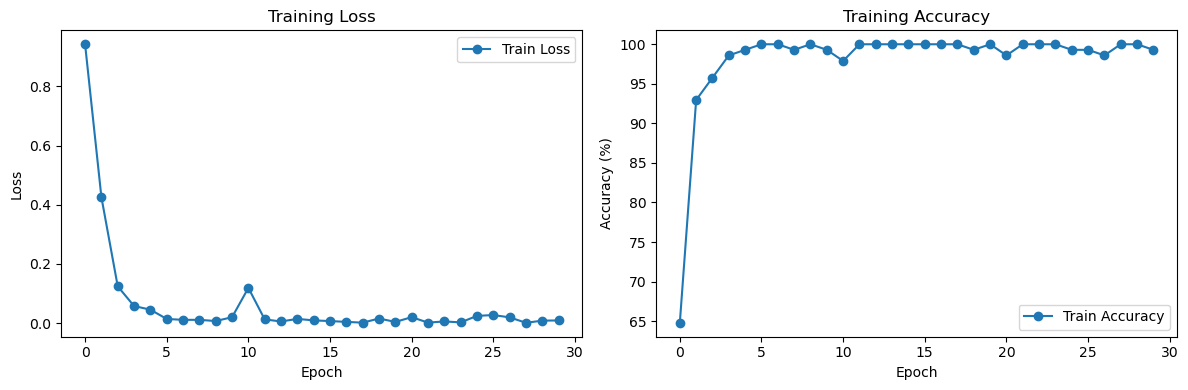

In [20]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(train_losses, '-o', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, '-o', label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
model.eval() 
test_correct = 0
test_total = 0
test_loss = 0.0

with torch.no_grad():  
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * features.size(0)

        # Predictions
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

avg_test_loss = test_loss / test_total
test_accuracy = 100.0 * test_correct / test_total

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 0.0002, Test Accuracy: 100.00%


In [24]:
model.eval()
with torch.no_grad():
    sample_features = torch.tensor(X_test[:5], dtype=torch.float32).to(device)
    outputs = model(sample_features)
    _, preds = torch.max(outputs, 1)

print("Predicted classes:", preds.cpu().numpy())
print("Actual classes:   ", y_test[:5])


Predicted classes: [0 0 2 0 1]
Actual classes:    [0 0 2 0 1]
